# Defining and Training Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from numpy import log, sqrt, log2, ceil, exp
import matplotlib.pyplot as plt

## Load Data

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.customer = sequences[:, :-1]
        self.vendor = sequences[:, -1:].view(-1)

    def __len__(self):
        return len(self.vendor)

    def __getitem__(self, idx):
        return self.customer[idx,:], self.vendor[idx]

In [3]:
with open("train_sequences_padded_dataset.pkl", "rb") as file:
    train_sequences_padded_dataset = pickle.load(file)

with open("vendors_tensor.pkl", "rb") as file:
    vendors_tensor = pickle.load(file)

## Define Model

### Model 1
<p align="center">
  <img src="Recommender1.png" width="1000"/>
</p>

In [4]:
# Define column indices to split columns into chunks (hard-coded)

cont_idx_lo = 0
cont_idx_hi = 8     # Up to avg_sale_log
misc_idx_hi = 12    # Up to rank
ptag_idx_hi = 55    # Up to primary_tags_is_42
vtag_idx_hi = 123   # Up to vendor_tag_is_67

In [5]:
print(ceil(log2(67)))   # vtag embed size

7.0


In [6]:
print(ceil(log2(42)))   # ptag embed size

6.0


In [7]:
print(2 * ceil(log2(12+6+7)))   # final embed size

10.0


In [8]:
class Model1(nn.Module):
    def __init__(self, vendors, cont_idx_hi, misc_idx_hi, ptag_idx_hi, vtag_idx_hi, d_fc):
        super(Model1, self).__init__()

        # for vendor lookup 
        self.vendor_lookup = nn.Embedding.from_pretrained(vendors)
        self.vendor_lookup.weight.requires_grad = False

        # indices for slicing inputs
        self.cont_idx_hi = cont_idx_hi
        self.misc_idx_hi = misc_idx_hi
        self.ptag_idx_hi = ptag_idx_hi
        self.vtag_idx_hi = vtag_idx_hi
        
        # dimensions of slices
        d_cont = cont_idx_hi
        d_misc = misc_idx_hi - cont_idx_hi
        d_ptag = ptag_idx_hi - misc_idx_hi
        d_vtag = vtag_idx_hi - ptag_idx_hi

        # primary_tags embeddings
        d_emb_ptag = int(ceil(log2(d_ptag)))
        self.c_emb_ptag = nn.Linear(d_ptag, d_emb_ptag)
        self.v_emb_ptag = nn.Linear(d_ptag, d_emb_ptag)

        # vendor_tag embeddings
        d_emb_vtag = int(ceil(log2(d_vtag)))
        self.c_emb_vtag = nn.Linear(d_vtag, d_emb_vtag)
        self.v_emb_vtag = nn.Linear(d_vtag, d_emb_vtag)

        # customer and vendor embeddings
        d_emb = int(ceil(log2(d_cont+d_misc+d_emb_ptag+d_emb_vtag)))
        self.c_emb = nn.Linear(d_cont+d_misc+d_emb_ptag+d_emb_vtag, d_emb)
        self.v_emb = nn.Linear(d_cont+d_misc+d_emb_ptag+d_emb_vtag, d_emb)

        # dense layers
        self.fc1 = nn.Linear(2 * d_emb, d_fc)
        self.fc2 = nn.Linear(d_fc, d_fc // 2)
        self.fc3 = nn.Linear(d_fc // 2, d_fc // 4)
        self.fc4 = nn.Linear(d_fc // 4, 1)


    def forward(self, c_seq, v_id):
        # lookup customer and vendor representations
        vendor = self.vendor_lookup(v_id)
        customer = torch.sum(self.vendor_lookup(c_seq), axis=1)     # correct axis?

        # split customer
        c_cont = customer[:, : self.cont_idx_hi]
        c_misc = customer[:, self.cont_idx_hi : self.misc_idx_hi]
        c_ptag = customer[:, self.misc_idx_hi : self.ptag_idx_hi]
        c_vtag = customer[:, self.ptag_idx_hi :]

        # split vendor
        v_cont = vendor[:, : self.cont_idx_hi]
        v_misc = vendor[:, self.cont_idx_hi : self.misc_idx_hi]
        v_ptag = vendor[:, self.misc_idx_hi : self.ptag_idx_hi]
        v_vtag = vendor[:, self.ptag_idx_hi :]

        # embed ptags
        c_ptag = self.c_emb_ptag(c_ptag.float())
        c_ptag = F.elu(c_ptag)

        v_ptag = self.v_emb_ptag(v_ptag.float())
        v_ptag = F.elu(v_ptag)

        # embed vtags
        c_vtag = self.c_emb_vtag(c_vtag.float())
        c_vtag = F.elu(c_vtag)

        v_vtag = self.v_emb_vtag(v_vtag.float())
        v_vtag = F.elu(v_vtag)

        # embed customer
        customer = torch.cat((c_cont, c_misc, c_ptag, c_vtag), axis=1)
        customer = self.c_emb(customer.float())
        customer = F.elu(customer)

        # embed vendor
        vendor = torch.cat((v_cont, v_misc, v_ptag, v_vtag), axis=1)
        vendor = self.v_emb(vendor.float())
        vendor = F.elu(vendor)

        # feed through classifier
        out = torch.cat((customer, vendor), axis=1)
        out = self.fc1(out)
        out = F.elu(out)

        out = self.fc2(out)
        out = F.elu(out)

        out = self.fc3(out)
        out = F.elu(out)

        out = self.fc4(out)     # output is raw
        return out

model1 = Model1(vendors=vendors_tensor, cont_idx_hi=cont_idx_hi, misc_idx_hi=misc_idx_hi, ptag_idx_hi=ptag_idx_hi, vtag_idx_hi=vtag_idx_hi, d_fc=64)

### Loss Function

To train our model, we will use a type of ranking loss function. A ranking loss takes as input the scores of a positive sample and a negative sample. The output is
$$\textrm{loss}(x_+, x_-) = \textrm{max}(0, x_- - x_+)$$
The loss is $0$ when the positive sample is ranked higher than or equal to the negative sample, and is greater than $0$ otherwise. 

In [9]:
mr_loss = nn.MarginRankingLoss()

### Optimizer

In [10]:
adam = torch.optim.Adam(model1.parameters())

## Training

In [11]:
# Define DataLoaders

batch_size = 512
num_workers = 0
train_loader = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [12]:
# Define the training process for Model 1

epochs = 100
print_every = 10
save_every = 10

train_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = torch.randint(low=1, high=100, size=v_id.size())

        # Get scores
        pos_pred = model1.forward(c_seq, v_id)
        neg_pred = model1.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()
        train_losses.append(batch_loss.item())

        # Update parameters
        batch_loss.backward()
        adam.step()

        # Reset gradients
        adam.zero_grad()
        
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]: sum(batch_losses) = {running_loss}')
    if epoch % save_every == 0:
        PATH = f"models/model1_epoch{epoch}.pkl"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model1.state_dict(),
            'optimizer_state_dict': adam.state_dict(),
            'loss': mr_loss,
            }, PATH)
print(f'Epoch [{epochs}/{epochs}]: sum(batch_losses) = {running_loss}')
PATH = f"models/model1_epoch{epochs}.pkl"
torch.save({
    'epoch': epochs,
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': mr_loss,
    }, PATH)
print('Done!')

Epoch [0/100]: sum(batch_losses) = 0.07639831304913969
Epoch [10/100]: sum(batch_losses) = 0.00027974779561645846
Epoch [20/100]: sum(batch_losses) = 7.536839976296505e-05
Epoch [30/100]: sum(batch_losses) = 1.6947492973429235e-05
Epoch [40/100]: sum(batch_losses) = 6.2219692225085055e-06
Epoch [50/100]: sum(batch_losses) = 4.394695958254147e-06
Epoch [60/100]: sum(batch_losses) = 3.311601623146032e-06
Epoch [70/100]: sum(batch_losses) = 2.2341127836611463e-06
Epoch [80/100]: sum(batch_losses) = 1.150861385301738e-06
Epoch [90/100]: sum(batch_losses) = 5.618745673174885e-07
Epoch [100/100]: sum(batch_losses) = 4.1436399755845343e-07
Done!


In [19]:
print(f'num batches: {len(train_losses)}')
print(f'batches per epoch: {len(train_losses) // epochs}')

num batches: 25800
batches per epoch: 258


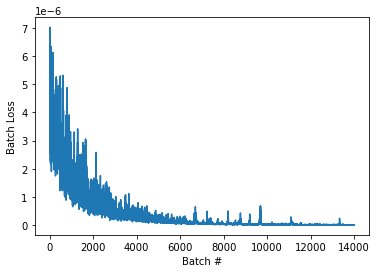

In [14]:
plt.plot(range(len(train_losses[1000:15000])), train_losses[1000:15000])
plt.xlabel('Batch #')
plt.ylabel('Batch Loss')
plt.show()